---


Name:- **Spandan Dixit**

---


Enrollment No.:- **18012011018**

---

Topic:- ***Case Study On  Dog breed classify with CNN & RESNET50 from scratch***


---

Exam:- **VIVA EXAM December-2021**

---

Semester:- **7**

---

Let's break the notebook into separate steps. Feel free to navigate the notebook and comment if you have any suggestions.

Step 0: Import Datasets \
Step 1: Detect Dogs\
Step 2: Create a CNN to Classify Dog Breeds (from Scratch)\
Step 3: Create a CNN to Classify Dog Breeds (using Transfer Learning)\
Step 4: Test

# Initializations
At first we need to import the libraries. It is considered as standard imports.


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.utils import make_grid

from PIL import Image
from IPython.display import display
import cv2
from PIL import ImageFile
import torchvision.transforms as transforms
ImageFile.LOAD_TRUNCATED_IMAGES = True

import glob
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab.

We will be using this function mostly everywhere to run our experiments deterministically. Random functions of Numpy and Pandas will behave deterministically after this. To learn more about Deterministic Neural Networks please check out [this notebook](https://www.kaggle.com/bminixhofer/deterministic-neural-networks-using-pytorch)

In [2]:
def seed_everything(seed=1234):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(42)

Have you wondered about why they use 42? Do you want to know about the reason behind 42? Look [Here ](https://en.wikipedia.org/wiki/Phrases_from_The_Hitchhiker%27s_Guide_to_the_Galaxy#Answer_to_the_Ultimate_Question_of_Life.2C_the_Universe_and_Everything_.2842.29):p



open kaggle and goto account section in bottom you will find create api key option.. click on it and it will download kaggle.json file.

creating api token to fetch dataset directly


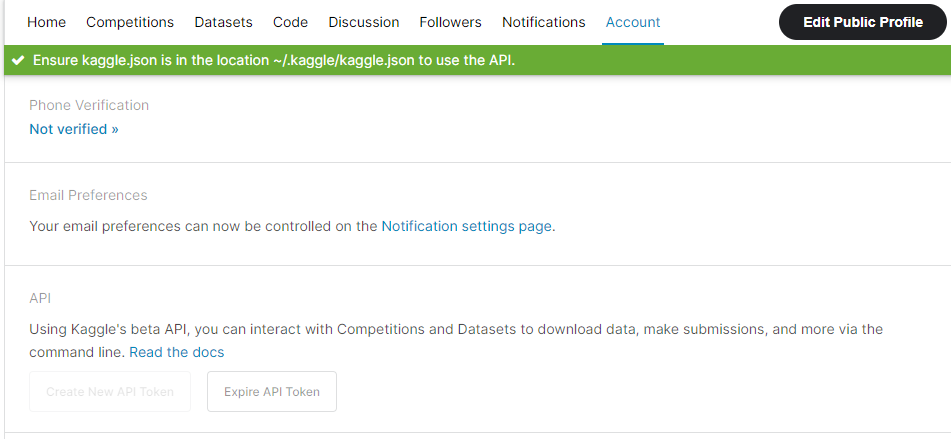

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
! pip install kaggle

In [4]:
! mkdir ~/.kaggle

In [5]:
from google.colab import files
print('upload kaggle.json')
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

upload kaggle.json


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [6]:
! cp kaggle.json ~/.kaggle/

In [7]:
! chmod 600 ~/.kaggle/kaggle.json

In [8]:
! kaggle datasets download carlosmiao/dogbreedidentification

 99% 681M/691M [00:08<00:00, 104MB/s]
100% 691M/691M [00:08<00:00, 84.9MB/s]


In [9]:
! unzip dogbreedidentification.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/83bc62b0fffa99a9c94ba0b67a5f7395.jpg  
  inflating: train/83bcff6b55ee179a7c123fa6103c377a.jpg  
  inflating: train/83be6d622ab74a5e7e08b53eb8fd566a.jpg  
  inflating: train/83c2d7419b0429b9fe953bc1b6cddbec.jpg  
  inflating: train/83cf7d7cd2a759a93e2ffd95bea9c6fb.jpg  
  inflating: train/83d405858f0931722ef21e8ac0adee4d.jpg  
  inflating: train/83d4125a4c3c7dc5956563276cb1cd74.jpg  
  inflating: train/83f0bb565b2186dbcc6a9d009cb26ff2.jpg  
  inflating: train/83fad0718581a696132c96c166472627.jpg  
  inflating: train/83fbbcc9a612e3f712b1ba199da61f20.jpg  
  inflating: train/8403d8936430c2f05ab7d74d23c2c0cb.jpg  
  inflating: train/8406d837b2d7fac1c3cd621abb4c4f9e.jpg  
  inflating: train/840b67d26e5e43f8eb6430f62d4ba1ac.jpg  
  inflating: train/840db91ba4600148f3dcb06ec419b421.jpg  
  inflating: train/840dbad5a691c22611d85b2488bf4cbb.jpg  
  inflating: train/8410ced9ebc1759a7ebce5c42bfb5222.jpg  
  inflating: train/84

all the files will looks as follows

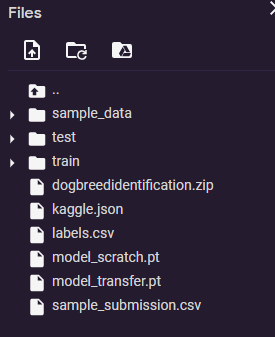

In [14]:
#Read the dataset 
labels = pd.read_csv('labels.csv')
labelnames = pd.read_csv('sample_submission.csv').keys()[1:]
print("Train folder has ", len(os.listdir('train')),'images which matches with label\'s', len(labels),'images')

Train folder has  10222 images which matches with label's 10222 images


In [15]:
labels.head(5)

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [16]:
codes = range(len(labelnames))
breed_to_code = dict(zip(labelnames, codes))
code_to_breed = dict(zip(codes, labelnames))
labels['target'] =  [breed_to_code[x] for x in labels.breed]
labels['rank'] = labels.groupby('breed').rank()[:1]
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.85)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(8689, 121) (1533, 121)


In [17]:
labels.head(5)

,id,breed,target,rank
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull,19,44.0
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo,37,NaN
2,001cdf01b096e06d78e9e5112d419397,pekinese,85,NaN
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick,15,NaN
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever,49,NaN


Using the code cell below to write three separate [data loaders](http://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) for the training, validation, and test datasets of dog images (located at `dog_images/train`, `dog_images/valid`, and `dog_images/test`, respectively).  You may find [this documentation on custom datasets](https://pytorch.org/vision/stable/datasets.html) to be a useful resource.  If you are interested in augmenting your training and/or validation data, check out the wide variety of [transforms](https://pytorch.org/vision/stable/transforms.html)!

In [18]:
 # Image transformations
img_transform = {
    'valid':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'train':transforms.Compose([
        transforms.RandomResizedCrop(size = 256),
        transforms.RandomRotation(degrees = 30),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),  
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])  
    ]),
    'test':transforms.Compose([
        transforms.Resize(size = 256),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

I resized the pictures to 256256 and then cropped the image into 224224 randomly to avoid squashed images and normalized it using Imagenet's mean and standard deviation after converting to tensor. for train, test and valid set.

For training images, I used data augmentation which includes random rotation of 30 degrees and horizontal flip.

In [19]:
class DogBreedDataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, img_dir, label, transform):
        'Initialization'
        self.img_dir = img_dir
        self.transform = transform
        self.label = label

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.label)

    def __getitem__(self, index):
        if self.label is not None:
            img_name = '{}.jpg'.format(self.label.iloc[index, 0])
            fullname = self.img_dir + img_name
            image = Image.open(fullname)
            label = self.label.iloc[index, 1:].astype('float').to_numpy()
            label = np.argmax(label)
            if self.transform:
                image = self.transform(image)
            return [image, label]
        

In [20]:
batch_size = 12
num_workers = 4
train_img = DogBreedDataset('train/', train, transform = img_transform['train'])
valid_img = DogBreedDataset('train/', valid, transform = img_transform['valid'])


dataloaders={
    'train':torch.utils.data.DataLoader(train_img, batch_size, num_workers = num_workers, shuffle=True),
    'valid':torch.utils.data.DataLoader(valid_img, batch_size, num_workers = num_workers, shuffle=False)
}


In [21]:
use_cuda = torch.cuda.is_available()

In [22]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

torch.Size([12, 3, 224, 224]) torch.Size([12])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

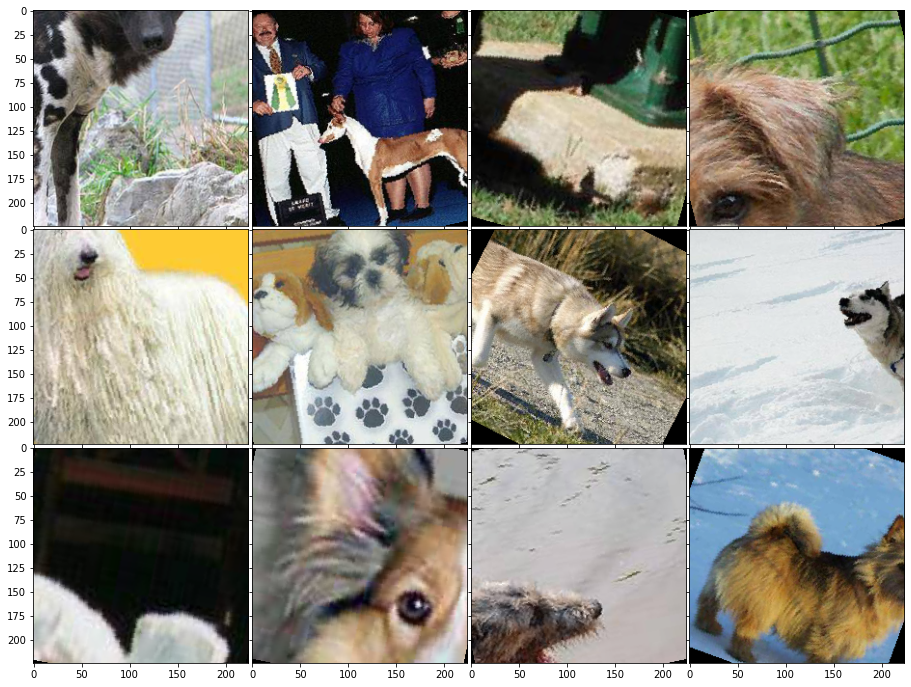

In [23]:
from mpl_toolkits.axes_grid1 import ImageGrid
img, label = next(iter(dataloaders['train']))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 12))
grid = ImageGrid(fig, 111, nrows_ncols=(3, 4), axes_pad=0.05)    
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])

# CNN Model from scratch

In [24]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        ## Define layers of a CNN
    
        # Convolution layers
        self.conv1 = nn.Conv2d(3, 32, 3, padding = 1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding = 1)
        self.conv3 = nn.Conv2d(64, 128, 3, padding = 1)
        
        # Max pooling layer (divides image size by 2)
        self.pool = nn.MaxPool2d(2, 2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 28 * 28, 500)
        self.fc2 = nn.Linear(500, 120)
        
        # Dropout
        self.dropout = nn.Dropout(0.3)
        
        
    def forward(self, x):
        ## Define forward behavior
        
        # Sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # Flatten image input
        x = x.view(-1, 128 * 28 * 28)
        # Dropout layer
        x = self.dropout(x)
        # 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # Dropout layer
        x = self.dropout(x)
        # 2nd hidden layer
        x = self.fc2(x)
        return x

# instantiate the CNN
model_scratch = Net()

# move tensors to GPU if CUDA is available
if use_cuda:
    model_scratch.cuda()

I used three convolutional layers with relu activations which are followed by maxpool layers. Also, used two fully connected layers. Between fully connected layers, dropout technique with probability = 0.25 is used to avoid the overfitting.

In [25]:
!pip install torchsummary

In [27]:
#let's see the model
from torchsummary import summary
summary(model_scratch, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 224, 224]             896
         MaxPool2d-2         [-1, 32, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]          18,496
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]          73,856
         MaxPool2d-6          [-1, 128, 28, 28]               0
           Dropout-7               [-1, 100352]               0
            Linear-8                  [-1, 500]      50,176,500
           Dropout-9                  [-1, 500]               0
           Linear-10                  [-1, 120]          60,120
Total params: 50,329,868
Trainable params: 50,329,868
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 27.57
Params size (MB): 191.99
Es

the next code cell to specify a [loss function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [optimizer](http://pytorch.org/docs/stable/optim.html).  

In [28]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_scratch.parameters(), lr=0.01, momentum = 0.9)

In [29]:
def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## find the loss and update the model parameters accordingly
            ## record the average training loss, using something like
            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss = train_loss + ((1 / (batch_idx + 1)) * (loss.data - train_loss))
            
            if batch_idx % 100 == 0:
                print('Epoch: %d \tBatch: %d \tTraining Loss: %.6f' %(epoch, batch_idx + 1, train_loss))
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            ## update the average validation loss
            output = model(data)
            loss = criterion(output, target)
            valid_loss = valid_loss + ((1 / (batch_idx + 1)) * (loss.data - valid_loss))
            
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.4f} \tValidation Loss: {:.4f}'.format(
            epoch, 
            train_loss,
            valid_loss
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            print('BOOM! Validation loss decreased ({:.4f} --> {:.4f}).  Saving model...'.format(valid_loss_min,valid_loss))
            valid_loss_min = valid_loss    

    # return trained model
    return model
# train the model
model_scratch = train(10, dataloaders, model_scratch, optimizer, 
                      criterion, use_cuda, 'model_scratch.pt')

# load the model that got the best validation accuracy
model_scratch.load_state_dict(torch.load('model_scratch.pt'))

Epoch: 1 	Batch: 1 	Training Loss: 4.788001
Epoch: 1 	Batch: 101 	Training Loss: 4.791423
Epoch: 1 	Batch: 201 	Training Loss: 4.788949
Epoch: 1 	Batch: 301 	Training Loss: 4.785952
Epoch: 1 	Batch: 401 	Training Loss: 4.781230
Epoch: 1 	Batch: 501 	Training Loss: 4.778362
Epoch: 1 	Batch: 601 	Training Loss: 4.773880
Epoch: 1 	Batch: 701 	Training Loss: 4.771429
Epoch: 1 	Training Loss: 4.7711 	Validation Loss: 4.6908
BOOM! Validation loss decreased (inf --> 4.6908).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 4.606475
Epoch: 2 	Batch: 101 	Training Loss: 4.715150
Epoch: 2 	Batch: 201 	Training Loss: 4.719244
Epoch: 2 	Batch: 301 	Training Loss: 4.721375
Epoch: 2 	Batch: 401 	Training Loss: 4.723135
Epoch: 2 	Batch: 501 	Training Loss: 4.724865
Epoch: 2 	Batch: 601 	Training Loss: 4.726171
Epoch: 2 	Batch: 701 	Training Loss: 4.727448
Epoch: 2 	Training Loss: 4.7272 	Validation Loss: 4.6752
BOOM! Validation loss decreased (4.6908 --> 4.6752).  Saving model...
Epoch: 3 	Batch: 

<All keys matched successfully>

as you can see it has a pretty big loss value. Training a model from scratch and getting good loss can be hard with epochs like 10. So let's move to transfer learning models which are pretrained. 

we can even use callbacks to stop if validation loss starts increases but right now we are not using callbacks...

In [30]:
resnet50 = models.resnet50(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [31]:
##  Specify model architecture 
model_transfer = models.resnet50(pretrained=True)

# Freeze training for all "features" layers
for param in model_transfer.parameters():
    param.requires_grad = False
    
# replace the last fully connected layer with a Linnear layer 133 output
in_features = model_transfer.fc.in_features
model_transfer.fc = nn.Linear(in_features, 120)

if use_cuda:
    model_transfer = model_transfer.cuda()

In [32]:
criterion_transfer = nn.CrossEntropyLoss()
model_transfer_grad_paramaters = filter(lambda p: p.requires_grad, model_transfer.parameters())
optimizer_transfer = torch.optim.SGD(model_transfer_grad_paramaters, lr=0.01)

In [ ]:
n_epochs = 5
# train the model
model_transfer = train(n_epochs, dataloaders, model_transfer, optimizer_transfer, criterion_transfer, use_cuda, 'model_transfer.pt')

Epoch: 1 	Batch: 1 	Training Loss: 4.816954
Epoch: 1 	Batch: 101 	Training Loss: 4.675233
Epoch: 1 	Batch: 201 	Training Loss: 4.519605
Epoch: 1 	Batch: 301 	Training Loss: 4.382110
Epoch: 1 	Batch: 401 	Training Loss: 4.251270
Epoch: 1 	Batch: 501 	Training Loss: 4.139781
Epoch: 1 	Batch: 601 	Training Loss: 4.028835
Epoch: 1 	Batch: 701 	Training Loss: 3.923740
Epoch: 1 	Training Loss: 3.9033 	Validation Loss: 2.5978
BOOM! Validation loss decreased (inf --> 2.5978).  Saving model...
Epoch: 2 	Batch: 1 	Training Loss: 3.587530
Epoch: 2 	Batch: 101 	Training Loss: 3.010753
Epoch: 2 	Batch: 201 	Training Loss: 2.965046
Epoch: 2 	Batch: 301 	Training Loss: 2.896155
Epoch: 2 	Batch: 401 	Training Loss: 2.827619
Epoch: 2 	Batch: 501 	Training Loss: 2.793928
Epoch: 2 	Batch: 601 	Training Loss: 2.760459
Epoch: 2 	Batch: 701 	Training Loss: 2.712293
Epoch: 2 	Training Loss: 2.7114 	Validation Loss: 1.6117
BOOM! Validation loss decreased (2.5978 --> 1.6117).  Saving model...
Epoch: 3 	Batch: 

by using resnet50 our validation loss decreased to 1.6...

# SubmissionAdam

In [ ]:
submission = pd.read_csv('sample_submission.csv')
output = pd.DataFrame(index=submission.index, columns=submission.keys() )
output['id'] = submission['id']
submission['target'] =  [0] * len(submission)